In this part, we are going to implement detectors for particular types of triangles: 1) **Equilateral** triangles - ones that have 3 equal sides (and 3 equal angles); 2) **Isosceles** triangles - Ones with two sides of equal length (and equal base angles); 3) **Right** triangles - ones that have a 90 degree angle;


# Functions for lines detection and edge mapping

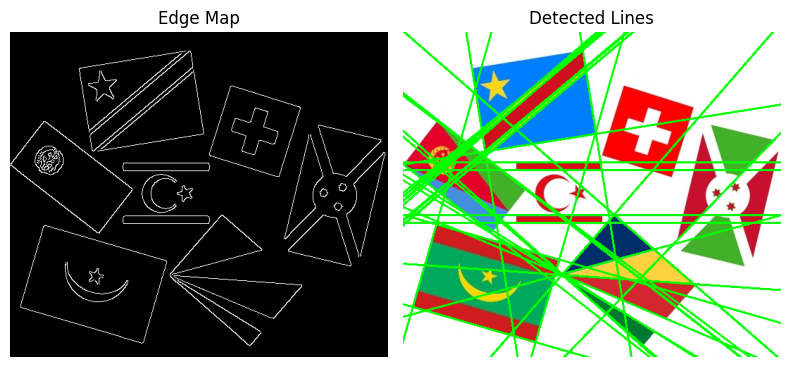

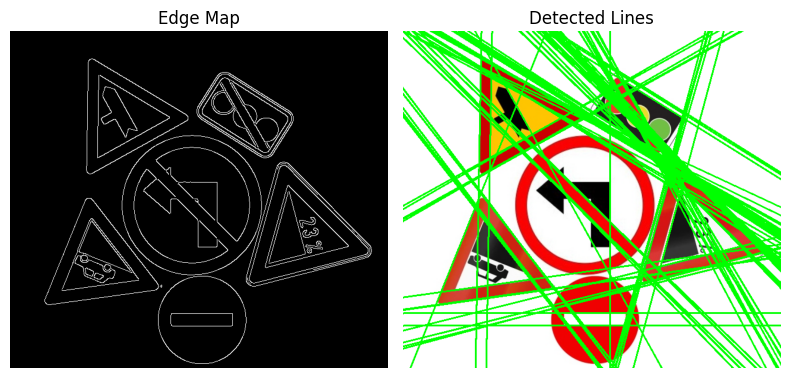

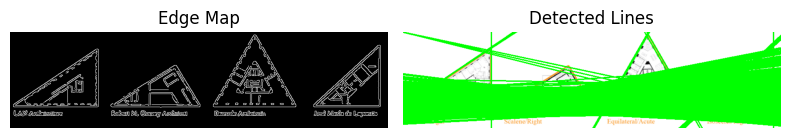

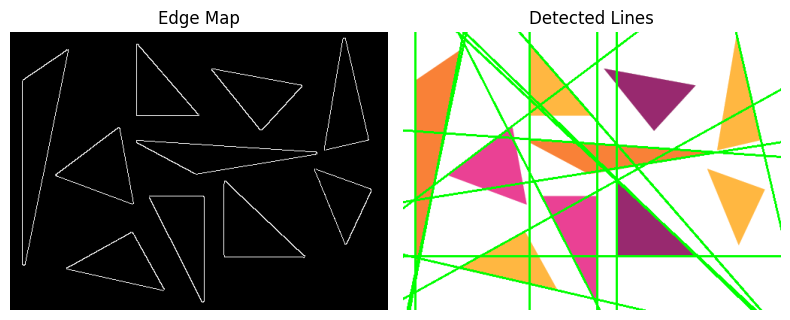

In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



def load_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_COLOR)

def preprocess_image(image, low_threshold=50, high_threshold=150):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, low_threshold, high_threshold, apertureSize=3)
    return edges

image_paths=["/content/flags1.jpg","/content/t_signs2.jpg","/content/sample_triangles.png","/content/what_is_a_triangle.png"]

# Ensure output folder exists
output_folder = '/content/sample_data/Untitled Folder'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
count = 0
edge_map_images = []
for i in image_paths:
  count += 1
  # Load the image
  image_path = i
  input_image = load_image(image_path)
  edge_map = preprocess_image(input_image, low_threshold=50, high_threshold=200)

  # Save edge map image
  edge_map_output_path = os.path.join(output_folder, f'edge_map{count}.png')
  cv2.imwrite(edge_map_output_path, edge_map)
  edge_map_images.append(edge_map)


  # Parameters
  window_size = 200
  step_size = 25
  threshold = 100

  # Apply Sliding-Window Hough Transform
  lines = hough_transform(edge_map, rho_res=1, theta_res=np.pi / 180, threshold=threshold)

  # Visualize detected lines
  hough_image = np.copy(input_image)
  for rho, theta in lines:
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      x1 = int(x0 + 1000 * (-b))
      y1 = int(y0 + 1000 * (a))
      x2 = int(x0 - 1000 * (-b))
      y2 = int(y0 - 1000 * (a))
      cv2.line(hough_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

  # # Save the image with detected lines
  # lines_output_path = os.path.join(output_folder, 'detected_lines.png')
  # cv2.imwrite(lines_output_path, hough_image)

  import matplotlib.pyplot as plt

  def visualize_results(edge_map, hough_image):
      # Create the figure and subplots
      fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100)

      # Display the edge map
      axes[0].imshow(edge_map, cmap='gray')
      axes[0].set_title('Edge Map')
      axes[0].axis('off')

      # Display the Hough image with detected lines
      axes[1].imshow(cv2.cvtColor(hough_image, cv2.COLOR_BGR2RGB))
      axes[1].set_title('Detected Lines')
      axes[1].axis('off')

      plt.tight_layout()
      plt.show()

  # Example usage
  # edge_map = ... (your edge map image)
  # hough_image = ... (your hough transform image)
  visualize_results(edge_map, hough_image)






# Fine tune code for Drawing image triangle detection

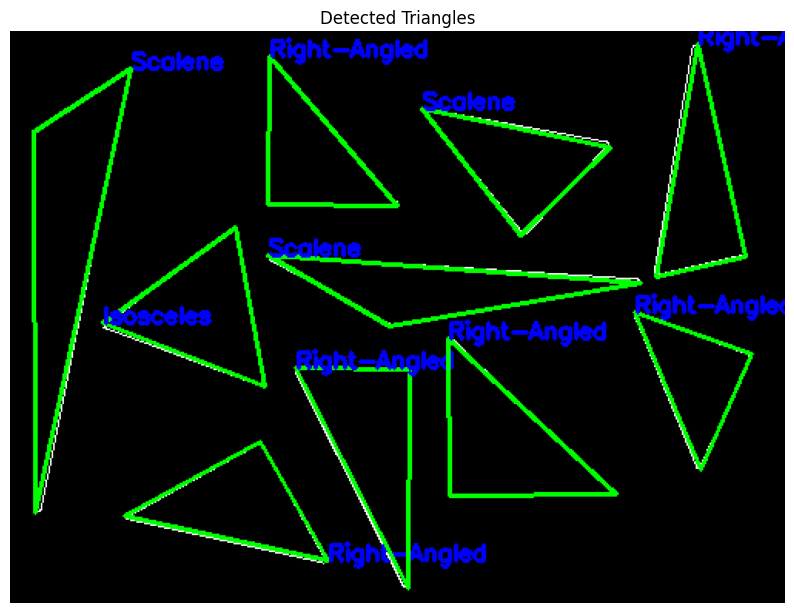

In [114]:
# Function to classify triangles
def classify_triangle(triangle):
    # Calculate lengths of sides
    side1 = side_length(triangle[0][0], triangle[1][0])
    side2 = side_length(triangle[1][0], triangle[2][0])
    side3 = side_length(triangle[2][0], triangle[0][0])

    # Calculate angles
    angle1 = np.arccos((side1**2 + side3**2 - side2**2) / (2 * side1 * side3))
    angle2 = np.arccos((side1**2 + side2**2 - side3**2) / (2 * side1 * side2))
    angle3 = np.arccos((side2**2 + side3**2 - side1**2) / (2 * side2 * side3))

    # Convert angles from radians to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Tolerance for comparing sides
    side_tolerance = 0.05 * max(side1, side2, side3)

    # Classify triangle based on angles and side lengths
    if np.isclose(side1, side2, atol=side_tolerance) and np.isclose(side2, side3, atol=side_tolerance):
        return "Equilateral"
    elif np.isclose(angle1_deg, 90, atol=5) or np.isclose(angle2_deg, 90, atol=5) or np.isclose(angle3_deg, 90, atol=5):
        return "Right-Angled"
    elif np.isclose(side1, side2, atol=side_tolerance) or np.isclose(side2, side3, atol=side_tolerance) or np.isclose(side1, side3, atol=side_tolerance):
        return "Isosceles"
    else:
        return "Scalene"

# Function to detect triangles in an image
def detect_triangles(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Detect edges using Canny edge detector
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the polygon has 3 vertices, it is a triangle
        if len(approx) == 3:
            triangles.append(approx)

    # Draw triangles on the original image and classify them
    output_image = image.copy()
    for triangle in triangles:
        cv2.drawContours(output_image, [triangle], 0, (0, 255, 0), 2)
        classification = classify_triangle(triangle)
        cv2.putText(output_image, classification, tuple(triangle[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return output_image
# Path to your image file
image_path = '/content/sample_data/Untitled Folder/edge_map4.png'

# Detect triangles
output_image = detect_triangles(image_path)

# Convert the image from BGR to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the output image with detected triangles
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title('Detected Triangles')
plt.axis('off')
plt.show()


# Fine Tune Code For T Sign Image triangles detection

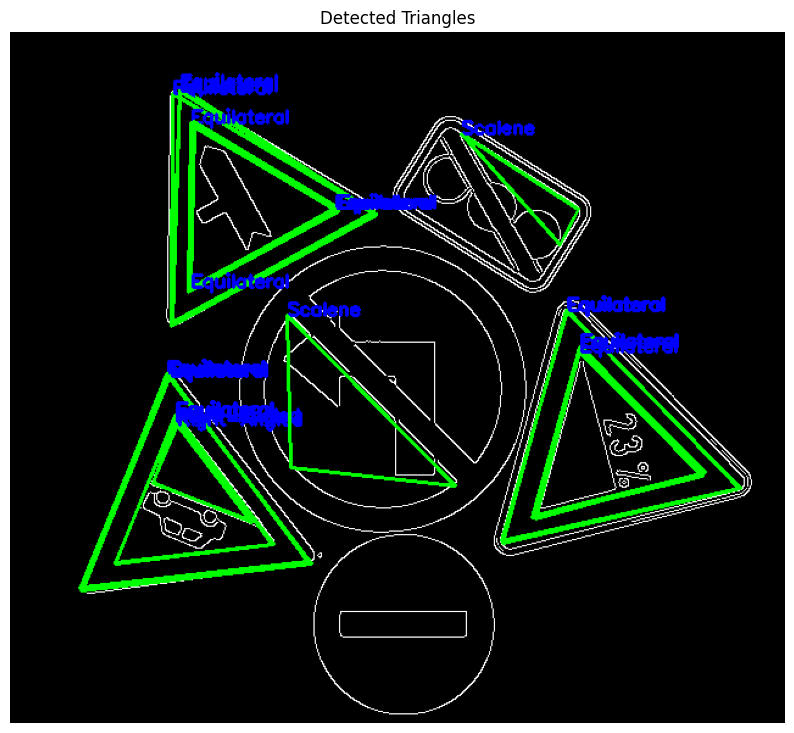

In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the length of a side given two points
def side_length(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to classify triangles
def classify_triangle(triangle):
    # Calculate lengths of sides
    side1 = side_length(triangle[0][0], triangle[1][0])
    side2 = side_length(triangle[1][0], triangle[2][0])
    side3 = side_length(triangle[2][0], triangle[0][0])

    # Calculate angles
    angle1 = np.arccos((side1**2 + side3**2 - side2**2) / (2 * side1 * side3))
    angle2 = np.arccos((side1**2 + side2**2 - side3**2) / (2 * side1 * side2))
    angle3 = np.arccos((side2**2 + side3**2 - side1**2) / (2 * side2 * side3))

    # Convert angles from radians to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Tolerance for comparing sides
    side_tolerance = 0.05 * max(side1, side2, side3)

    # Classify triangle based on angles and side lengths
    if np.isclose(side1, side2, atol=side_tolerance) and np.isclose(side2, side3, atol=side_tolerance):
        return "Equilateral"
    elif np.isclose(angle1_deg, 90, atol=5) or np.isclose(angle2_deg, 90, atol=5) or np.isclose(angle3_deg, 90, atol=5):
        return "Right-Angled"
    elif np.isclose(side1, side2, atol=side_tolerance) or np.isclose(side2, side3, atol=side_tolerance) or np.isclose(side1, side3, atol=side_tolerance):
        return "Isosceles"
    else:
        return "Scalene"

# Function to detect triangles in an image
def detect_triangles(image_path, min_area=100):  # min_area is the minimum area threshold for filtering out small dots
    # Load the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Detect edges using Canny edge detector
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image, using cv2.RETR_TREE to get all contours including nested ones
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) < min_area:
            continue

        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the polygon has 3 vertices, it is a triangle
        if len(approx) == 3:
            triangles.append(approx)

    # Draw triangles on the original image and classify them
    output_image = image.copy()
    for triangle in triangles:
        cv2.drawContours(output_image, [triangle], 0, (0, 255, 0), 2)
        classification = classify_triangle(triangle)
        cv2.putText(output_image, classification, tuple(triangle[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return output_image

# Path to your image file
image_path = '/content/sample_data/Untitled Folder/edge_map2.png'

# Detect triangles
output_image = detect_triangles(image_path)

# Convert the image from BGR to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the output image with detected triangles
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title('Detected Triangles')
plt.axis('off')
plt.show()


# Fine Tune Code For Flage Triangles Detection

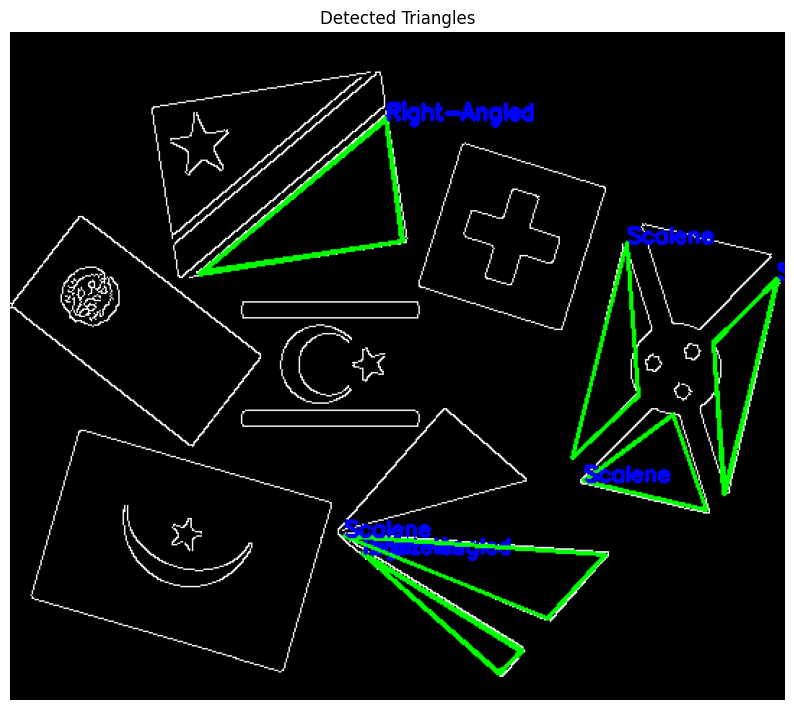

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the length of a side given two points
def side_length(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to classify triangles
def classify_triangle(triangle):
    # Calculate lengths of sides
    side1 = side_length(triangle[0][0], triangle[1][0])
    side2 = side_length(triangle[1][0], triangle[2][0])
    side3 = side_length(triangle[2][0], triangle[0][0])

    # Calculate angles
    angle1 = np.arccos((side1**2 + side3**2 - side2**2) / (2 * side1 * side3))
    angle2 = np.arccos((side1**2 + side2**2 - side3**2) / (2 * side1 * side2))
    angle3 = np.arccos((side2**2 + side3**2 - side1**2) / (2 * side2 * side3))

    # Convert angles from radians to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Tolerance for comparing sides
    side_tolerance = 0.05 * max(side1, side2, side3)

    # Classify triangle based on angles and side lengths
    if np.isclose(side1, side2, atol=side_tolerance) and np.isclose(side2, side3, atol=side_tolerance):
        return "Equilateral"
    elif np.isclose(angle1_deg, 90, atol=5) or np.isclose(angle2_deg, 90, atol=5) or np.isclose(angle3_deg, 90, atol=5):
        return "Right-Angled"
    elif np.isclose(side1, side2, atol=side_tolerance) or np.isclose(side2, side3, atol=side_tolerance) or np.isclose(side1, side3, atol=side_tolerance):
        return "Isosceles"
    else:
        return "Scalene"

# Function to detect triangles in an image
def detect_triangles(image_path, min_area=100):  # min_area is the minimum area threshold for filtering out small dots
    # Load the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Detect edges using Canny edge detector
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image, using cv2.RETR_TREE to get all contours including nested ones
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) < min_area:
            continue

        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the polygon has 3 vertices, it is a triangle
        if len(approx) == 3:
            triangles.append(approx)

    # Draw triangles on the original image and classify them
    output_image = image.copy()
    for triangle in triangles:
        cv2.drawContours(output_image, [triangle], 0, (0, 255, 0), 2)
        classification = classify_triangle(triangle)
        cv2.putText(output_image, classification, tuple(triangle[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return output_image

# Path to your image file
image_path = '/content/sample_data/Untitled Folder/edge_map1.png'

# Detect triangles
output_image = detect_triangles(image_path)

# Convert the image from BGR to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the output image with detected triangles
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title('Detected Triangles')
plt.axis('off')
plt.show()


# Fine Tune Code For Natural image triangle detection

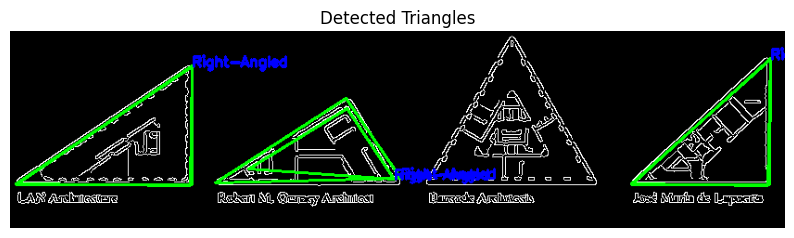

In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the length of a side given two points
def side_length(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to classify triangles
def classify_triangle(triangle):
    # Calculate lengths of sides
    side1 = side_length(triangle[0][0], triangle[1][0])
    side2 = side_length(triangle[1][0], triangle[2][0])
    side3 = side_length(triangle[2][0], triangle[0][0])

    # Calculate angles
    angle1 = np.arccos((side1**2 + side3**2 - side2**2) / (2 * side1 * side3))
    angle2 = np.arccos((side1**2 + side2**2 - side3**2) / (2 * side1 * side2))
    angle3 = np.arccos((side2**2 + side3**2 - side1**2) / (2 * side2 * side3))

    # Convert angles from radians to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Tolerance for comparing sides
    side_tolerance = 0.05 * max(side1, side2, side3)

    # Classify triangle based on angles and side lengths
    if np.isclose(side1, side2, atol=side_tolerance) and np.isclose(side2, side3, atol=side_tolerance):
        return "Equilateral"
    elif np.isclose(angle1_deg, 90, atol=5) or np.isclose(angle2_deg, 90, atol=5) or np.isclose(angle3_deg, 90, atol=5):
        return "Right-Angled"
    elif np.isclose(side1, side2, atol=side_tolerance) or np.isclose(side2, side3, atol=side_tolerance) or np.isclose(side1, side3, atol=side_tolerance):
        return "Isosceles"
    else:
        return "Scalene"

# Function to detect triangles in an image
def detect_triangles(image_path, min_area=500):  # min_area is the minimum area threshold for filtering out small dots
    # Load the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Detect edges using Canny edge detector
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image, using cv2.RETR_TREE to get all contours including nested ones
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        # Filter out small contours based on area
        if cv2.contourArea(contour) < min_area:
            continue

        # Approximate the contour to a polygon
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the polygon has 3 vertices, it is a triangle
        if len(approx) == 3:
            triangles.append(approx)

    # Draw triangles on the original image and classify them
    output_image = image.copy()
    for triangle in triangles:
        cv2.drawContours(output_image, [triangle], 0, (0, 255, 0), 2)
        classification = classify_triangle(triangle)
        cv2.putText(output_image, classification, tuple(triangle[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return output_image

# Path to your image file
image_path = '/content/sample_data/Untitled Folder/edge_map3.png'

# Detect triangles
output_image = detect_triangles(image_path)

# Convert the image from BGR to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the output image with detected triangles
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title('Detected Triangles')
plt.axis('off')
plt.show()


1. Stages of the Solution:

Edge Detection (Canny): First, the grayscale image is passed through the Canny edge detection algorithm to detect edges in the image.

Hough Transform for Line Detection: The detected edges are then processed using the Hough Transform to detect lines in the image.

Triangle Detection: Triangles are detected by finding contours in the edge-detected image and approximating polygons with three vertices.

Classification: Triangles are classified based on their side lengths and angles.

Visualization: Finally, the grayscale image, detected lines, and detected triangles are visualized using matplotlib.

2. Problems/Difficulties Encountered:

Parameter Tuning: Finding the optimal parameters for edge detection, Hough Transform, and triangle detection required experimentation and fine-tuning.

Handling Image Variability: The solution may not perform well on images with varying lighting conditions, noise, or complex backgrounds.

3. Limitations of the Approach:

Dependency on Input Image: The effectiveness of the solution depends heavily on the characteristics of the input image, such as contrast, clarity, and complexity.

Limited to Planar Triangles: The solution may not accurately detect triangles that are not well-defined or do not lie in a plane.

Sensitivity to Parameters: Small changes in parameters such as threshold values can significantly affect the detection and classification accuracy.

Thank you